<a href="https://colab.research.google.com/github/Freddy-94/GeneticAlgorithms/blob/main/GeneticAlgorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alfredo Bernal Luna
### Practice No. 3. Genetic Algorithms.

# Modules to be used in this program:

In [ ]:
import numpy as np
from numpy import sqrt, cos, e, pi, exp # for Ackley's function plot
import math
import random
import itertools
from decimal import Decimal
import matplotlib.pyplot as plt  # to plot

# Definition of cost functions:

1. Parabola.

   Let $f : {[-5.12, 5.12]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = \sum_{i=1}^n x_{i}^{2} 
  \end{align}

2. Rosenbrock's function.

   Let $f : {[-2.048, 2.048]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = \sum_{i=1}^n 100 (x_{i}^{2} - x_{i+1})^{2} + (1 - x_{i})^{2}
  \end{align}

3. Ackley's function.

   Let $f : {[-32.768, 32.768]} ^n \to \mathbb{R}$ given by:

  \begin{align}
          f(\mathbf{x}) = -20\mathrm{e}^{-0.2\sqrt{1/n\sum_{i=1}^n x_{i}^{2}}} - \mathrm{e}^{1/n\sum_{i=1}^n \cos {2\pi x_{i}}} + 20 + \mathrm{e}
  \end{align}

In [1]:
def parabola(n, x):
    parabola_value = 0
    for i in range(0, n):
        parabola_value += x[i]**2
    return parabola_value

def rosenbrock(n, x):
    sum = 0
    for i in range(0, n-1):
        sum += ((100 * (x[i]**2 - x[i+1])**2) + (1 - x[i])**2)
    rosenbrock_value = sum
    return rosenbrock_value

def ackley(n, x): 
    gen_cos_avg = 0
    root_mean_square = 0
    for i in range(0, n):
        gen_cos_avg += cos(2*pi*x[i])
        root_mean_square += x[i]**2
    root_mean_square = sqrt((1/n)*(root_mean_square))
    gen_cos_avg /= n          
    ackley = -20*exp((-0.2)*(root_mean_square)) - exp(gen_cos_avg) +  20 + e
    return ackley

# Test of the cost functions (dimension = 10):

**1.   Parabola:**

In [ ]:
parabola(10, [3.1315, 2.6548, 1.265, 0.264, 0.00156, 2.165, 3.125, 2.568, 1.698, 1.145])

43.765881723599996

**2. Rosenbrock:**

In [ ]:
rosenbrock(10, [1.0261, -1.6548, -1.265, 0.264, 0.00156, -2.0165, -0.1235, 2.0326, 1.698, 1.145])

6003.8176985519785

**3. Ackley:**

In [ ]:
ackley(10, [31.0261, -31.6548, -21.265, 20.264, 10.00156, -20.0165, -30.1235, 20.0326, 10.698, 10.145])

-45.61924996821731

# Graphs of cost functions, in 3D:

In [ ]:
def plot_cost_function_3d(vars_domain, num_points_to_plot, cost_fun):
    """
    Function to plot the graphs of the cost functions, in 3 dimensions. This function might be 
    useful to gain more intuition on the problem at hand
    """
    x1 = np.linspace(vars_domain[0], vars_domain[1], num_points_to_plot)
    x2 = x1
    coord_array_x1, coord_array_x2 = np.meshgrid(x1, x2)
    cost = cost_fun(2, [coord_array_x1, coord_array_x2]) 
    fig = plt.figure()
    ax = plt.axes(projection = '3d')
    ax.plot_surface(coord_array_x1, coord_array_x2, cost, rstride = 1, cstride = 1,
                    cmap = 'viridis', edgecolor = 'none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.show()

**1.   Parabola:** 

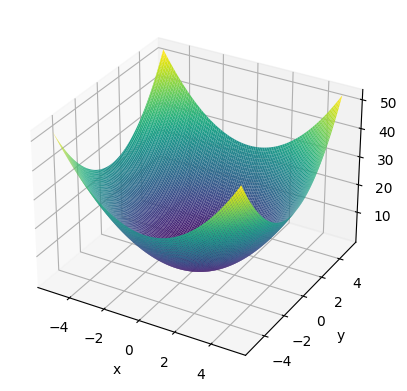

In [ ]:
plot_cost_function_3d([-5.12, 5.12], 100, parabola)

**2. Rosenbrock:** 

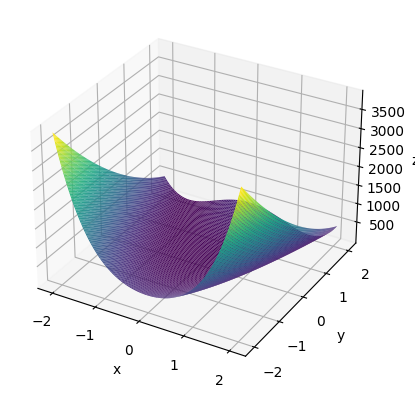

In [ ]:
plot_cost_function_3d([-2.048, 2.048], 100, rosenbrock)

**3. Ackley:**

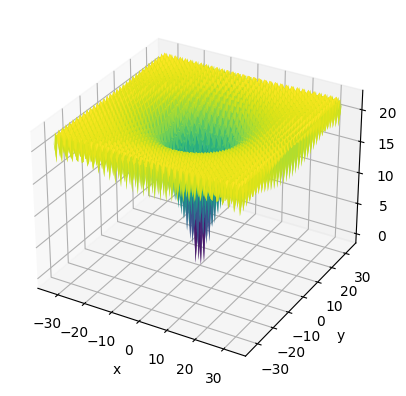

In [ ]:
plot_cost_function_3d([-32.768, 32.768], 100, ackley)

# Binary encoding (decoding) of variables of cost functions:

In [ ]:
def bit_size_binary(lim_inf, lim_sup, precision):
    """
    Function to obtain the number of bits needed in order to convert from decimal representation
    to binary.
    """
    bit_size = math.log((lim_sup) * (10**precision) - (lim_inf) * (10**precision), 2)
    return math.ceil(bit_size)

def int_to_bin(num, bit_size = 10):
    """
    Function to convert an integer from decimal representation, to a binary representation, given
    the size of the representation we want to show; i.e., given the number of bits we are given.
    """
    bin = ""
    power = 1
    while power <= num//2:
        power *= 2
    while power > 0:
        if num < power:
            bin += "0"
        else:
            bin += "1"
            num -= power
        power //= 2
    return bin.zfill(bit_size)
    
def binary_coding_dict(bit_size, lim_inf, lim_sup, precision):
    """
    This function generates a dictionary of a decimal representation of a value that a 
    variable in the interval might take, along with its corresponding binary representation; i.e.,
    the set of keys of the dictionary consists of the decimal representations of a value that a variable
    in the interval might take, with some given precision, and its values are the corresponding binary
    representations of the decimal representation.

    bit_size is the size of the binary representation that we'll be using to represent each one of its coordinates.
    lim_inf and lim_sup, are the corresponding bounds of the interval that all of our variables can take. This means that 
    our program currently supports only representations for variables having the same domain; i.e., vectors in a domain 
    of the form: [a,b]x[a,b]x...x[a,b].
    Hence, this also means that our program currently works for functions f of the form:
    
    f : [a,b]x[a,b]x...x[a,b] -> R
    """
    dict_binary_coding = {}
    prec = 1 * (10**(-precision))
    count = 0
    """
    while loop to obtain all possible values that a variable can take
    """    
    while  round(lim_inf, precision) <= round(lim_sup, precision):
        dict_binary_coding[lim_inf] = int_to_bin(count, bit_size)
        count += 1
        lim_inf = round(lim_inf + prec, precision)
    return dict_binary_coding        
            
def binary_encoding(x, prec, bin_coding_dict):
    """
    This function recover the binary representation for all of the variables that the 
    input of the cost function might take, and returns it's corresponding vector in a 
    string binary representation.
    x is the input vector in decimal representation, and bin_coding_dict
    is the dictionary obtained in the function binary_coding_dict above.    
    """
    bin_vector = []
    # print(bin_coding_dict)
    for i in range(0, len(x)):
        try:
            bin_vector.append(bin_coding_dict[round(x[i], prec)])
        except:
            print(f"\nThe function is not defined for the passed number: {x[i]}\n")
            print(f"Please provide an accurate input for coordinate: {i+1}\n")
    return bin_vector

def binary_decoding(bin_vector, bin_coding_dict):
    """
    This function recover the "original" vector in its decimal representation, given we pass its
    binary representation, by querying the dictionary having the decimal and associated binary 
    representations, defined in the function above. Notice this implementation might not be very
    efficient, so that's why we program the below function (so there's no need to build a dict)
    each time we need to decode a binary vector. However, we think it was helpful to see that
    below formula actually works, by taking a peak at this dict
    """
    decoded_vector = []
    for coordinate in bin_vector:
        decimals = [dec for dec, bin in bin_coding_dict.items() if bin == coordinate]
        decoded_vector += decimals   
    return decoded_vector

def bin_decoding_no_dict(bin_vector, lim_sup, precision):
    """
    Binary decoding function for a given bin_vector, and a given precision.
    As per above implementations, we are considering vectors that share the same
    domain, for each one of its variables; i.e., the input vector can take values
    in a domain of the form:  [a, b] x [a, b] x ... x [a, b]
    This is the same as the functions that our current program can handle.
    """
    dec_vect = []
    for bin_repr in bin_vector:
        bin_repr = bin_repr[::-1] # reverse current binary representation
        dec_repr = 0
        for i in range(len(bin_repr)):
            if bin_repr[i] == '1':
                dec_repr += 2**i
        dec_repr = round((dec_repr/(10**precision))-lim_sup, precision+1)
        dec_vect.append(dec_repr)
    return dec_vect
       

# Test of binary decoding function with no dict, for a vector in $\mathbb{R}^{3}$. Notice we need to provide the liminf of each one of the variables. In our particular solution, we are assuming that all of the variables are in the same interval \[a, b].

In [ ]:
bin_decoding_no_dict(['00100110101001110', '10100001010110010', '10010000010111011'], 5.12,  4)

[-3.141, 3.141, 2.2715]

# Test of binary coding for vectors in $\mathbb{R}^{3}$, for cost functions defined in its corresponding domain, with a precision of 4 decimal digits. Note that we can give to the function any dimension of $\mathbb{R}^{n}$, along with any precision we wish.

**1.   Parabola's domain:** 

In [ ]:
numer_bits_available = bit_size_binary(-5.12, 5.12, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -5.12, 5.12, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [-3.1410, 3.1410, 2.2715]
vector_in_binary = binary_encoding(vector_to_encode, 4, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['00100110101001110', '10100001010110010', '10010000010111011']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [ ]:
print([bin_dict[-3.1410], bin_dict[3.1410], bin_dict[2.2715]])

['00100110101001110', '10100001010110010', '10010000010111011']


**2. Rosenbrock's domain:** 

In [ ]:
numer_bits_available = bit_size_binary(-2.048, 2.048, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -2.048, 2.048, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [-1.1410, 0.1410, 2.0215]
vector_in_binary = binary_encoding(vector_to_encode, 4, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['0010001101101110', '0101010110000010', '1001111011110111']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [ ]:
print([bin_dict[-1.1410], bin_dict[0.1410], bin_dict[2.0215]])

['0010001101101110', '0101010110000010', '1001111011110111']


**3. Ackley's domain:**

In [ ]:
numer_bits_available = bit_size_binary(-32.768, 32.768, 4) # Number of bits that the variables in the parabola function can take, given its definition
bin_dict = binary_coding_dict(numer_bits_available, -32.768, 32.768, 4) # Dictionary storing the variables representation in decimal, with a precision of 4 decimal values
vector_to_encode = [-30.1410, 20.1410, 15.0215]
vector_in_binary = binary_encoding(vector_to_encode, 4, bin_dict) # Input vector in decimal representation, converted to binary vector  
print(vector_in_binary)

['00000110011010011110', '10000001001011000010', '01110100101011000111']


# Decimal-Binary dict to verify that the encoding was done effectively:

In [ ]:
print([bin_dict[-30.1410], bin_dict[20.1410], bin_dict[15.0215]])

['00000110011010011110', '10000001001011000010', '01110100101011000111']


# Cross-over Classes to implement different types of cross-over operators. Particularly, in this program we're considering only two. Namely, two cross-over and uniform cross-over operators:

In [ ]:
class TwoCrossover:
    def __init__(self, parent1, parent2):
        self.parent1 = parent1
        self.parent2 = parent2

    def crossover(self, cut_point1, cut_point2):
        """
        Implementation of the two crossover operator
        """
        children = []
        child1 = self.parent1[:cut_point1] + self.parent2[cut_point1:cut_point2] + self.parent1[cut_point2:]
        children.append(child1)
        child2 = self.parent2[:cut_point1] + self.parent1[cut_point1:cut_point2] + self.parent2[cut_point2:]
        children.append(child2)
        return children    

class UniformCrossover:
    def __init__(self, parent1, parent2):
        self.parent1 = parent1
        self.parent2 = parent2

    def crossover(self, prob_vect, cross_perc):
        """
        Implementation of the uniform crossover operator
        prob_vect is a probability vector generated by np.random.rand(n),
        where n is the length of the parents
        """
        for i in range(len(prob_vect)):
            # print(prob_vect[i]) to validate that the unifor crossover operation is implemented correctly
            if prob_vect[i] < cross_perc:
                self.parent1[i], self.parent2[i] = self.parent2[i], self.parent1[i]
        return [self.parent1, self.parent2]

# Mutation operator:

In [ ]:
def mutation(chromosome, delta, mut_perc):
    """
    Implementation of the mutation operator 
    """
    new_chrom = []
    for gen in chromosome:
        if random.uniform(0,1) <= mut_perc:
            if random.uniform(0,1) <= 0.5:
                gen += delta
            else:
                gen -= delta
        new_chrom.append(gen)
    return new_chrom

# Genetic algorithm implementation.

## Random initial population:

In [ ]:
def initial_population(population_size, vars_domain, dim, precision): 
    """
    This function creates the initial random population to start the algorithm.
    population_size must be an even number, in order to create the tournament. See below 
    bin_tournament function.
    """    
    population = []
    for i in range(0, population_size):
        individual = []    
        for i in range(0, dim):
            individual.append(round(random.uniform(vars_domain[0], vars_domain[1]), precision))
        population.append(individual)
    return population

## Test random initial population (20 individuals for parabola cost function, in dim = 10, with precision of two decimal digits):

In [ ]:
population = initial_population(20, [-5.12, 5.12], 10, 2)
population

[[2.79, -1.68, -5.01, 3.11, -5.07, 0.96, -4.69, 0.06, 4.47, -2.38],
 [4.06, -4.78, 0.47, 2.6, -2.07, 1.92, 4.03, 3.5, 0.77, -4.22],
 [4.34, 2.09, -1.24, 3.01, -4.11, -2.75, -4.73, -1.2, 0.55, 4.33],
 [3.83, 0.85, -1.32, 1.3, 4.43, 0.18, -4.04, -2.2, 4.71, -0.16],
 [-0.41, 1.38, 3.09, -1.18, -1.51, 2.25, 5.02, 1.49, 3.93, -0.52],
 [3.3, 3.74, 0.25, -0.9, 3.84, 4.23, -3.42, -1.86, -2.81, -0.29],
 [-3.07, -4.99, -3.53, 0.38, -0.95, 2.09, -3.87, 3.35, 0.92, -2.94],
 [-2.01, -2.88, 0.74, 0.04, -4.61, 3.86, -3.47, 4.73, -2.95, -0.17],
 [-4.88, 3.89, 0.2, 2.06, 1.28, 2.33, -2.67, 0.17, 0.96, -2.59],
 [-0.23, 0.37, -4.25, -4.9, 5.11, 5.07, 0.33, 4.36, -3.44, -3.98],
 [-5.12, 1.4, -1.26, -3.55, 4.64, -2.01, 0.31, -3.72, 1.26, 2.56],
 [2.96, -1.97, -3.24, 3.51, 3.01, 2.61, 2.14, 4.64, -1.61, -1.2],
 [4.58, 2.24, 4.19, -1.48, -0.38, -1.72, -1.21, -2.67, -0.34, 2.6],
 [1.62, 4.48, -2.38, -0.16, -2.7, 4.38, 2.42, 4.3, -1.73, -4.41],
 [0.35, -1.53, 1.78, -3.55, 2.2, 2.58, 2.42, 2.59, 3.36, 0.17],
 [

## Table of individuals, with their corresponding apptitudes (evaluation of cost function). 

In [ ]:
def table_pop_fitnesss(population, cost_fun):
    """
    This function provides a list of lists, showing the initial population, along its 
    corresponding aptitudes (their corresponding values that are obtained after evaluating
    the given cost function)
    """
    table = []
    for individual in population:
        table += [[individual, cost_fun(len(individual), individual)]]
    return table

## Test for the table of individuals, with their corresponding apptitudes (parabola cost function). Notice we are testing with the above random population obtained. 

In [ ]:
fitness_table = table_pop_fitnesss(population, parabola)
fitness_table

[[[2.79, -1.68, -5.01, 3.11, -5.07, 0.96, -4.69, 0.06, 4.47, -2.38],
  119.65019999999998],
 [[4.06, -4.78, 0.47, 2.6, -2.07, 1.92, 4.03, 3.5, 0.77, -4.22], 101.1764],
 [[4.34, 2.09, -1.24, 3.01, -4.11, -2.75, -4.73, -1.2, 0.55, 4.33],
  101.12029999999999],
 [[3.83, 0.85, -1.32, 1.3, 4.43, 0.18, -4.04, -2.2, 4.71, -0.16], 81.8524],
 [[-0.41, 1.38, 3.09, -1.18, -1.51, 2.25, 5.02, 1.49, 3.93, -0.52],
  63.491400000000006],
 [[3.3, 3.74, 0.25, -0.9, 3.84, 4.23, -3.42, -1.86, -2.81, -0.29],
  81.52480000000001],
 [[-3.07, -4.99, -3.53, 0.38, -0.95, 2.09, -3.87, 3.35, 0.92, -2.94], 87.8903],
 [[-2.01, -2.88, 0.74, 0.04, -4.61, 3.86, -3.47, 4.73, -2.95, -0.17], 92.1806],
 [[-4.88, 3.89, 0.2, 2.06, 1.28, 2.33, -2.67, 0.17, 0.96, -2.59],
  65.08489999999999],
 [[-0.23, 0.37, -4.25, -4.9, 5.11, 5.07, 0.33, 4.36, -3.44, -3.98],
  140.87180000000004],
 [[-5.12, 1.4, -1.26, -3.55, 4.64, -2.01, 0.31, -3.72, 1.26, 2.56], 90.0099],
 [[2.96, -1.97, -3.24, 3.51, 3.01, 2.61, 2.14, 4.64, -1.61, -1.2], 8

## Stochastic reminder parents selection without replacement.

In [ ]:
def stoch_rem_par_sel(table_pop_fitness):
    """
    Stochastic reminder parents selection without replacement implementation
    Notice this function has already the individuals (in decimal representation),
    along with its corresponding aptitudes (values output by the cost function)
    """
    total_fitness = 0
    exp_val_vector = [] # expected value vector that will have the expected values for each of the individuals of the population
    for i in range(len(table_pop_fitness)):
        total_fitness += table_pop_fitness[i][1]
        exp_val_vector.append(table_pop_fitness[i][1])
    avg_fitness = total_fitness/len(table_pop_fitness)
    exp_val_vector = np.array(exp_val_vector) # converted to a numpy array to perform division easier
    exp_val_vector = exp_val_vector/avg_fitness
    exp_val_vector = exp_val_vector.tolist()  # convert again to a list
    dec_exp_val_vector = [] # Vector that will contain the decimal part of the expected values
    parents = [] # Vector that will have the selected parents to reproduce
    for exp_val in exp_val_vector:
        exp_val_dec = round(exp_val % 1, 2) # decimal part of the expected values, with a precision of 2 decimal values
        dec_exp_val_vector.append(exp_val_dec)
        exp_val_int = int(exp_val) # integer part of each expected value
        if exp_val_int > 0:
            parents += [table_pop_fitness[exp_val_vector.index(exp_val)]] * exp_val_int   # posicion (index) in table pop fitness is the same as the expected values vector 
    for dec_exp_val in dec_exp_val_vector:
        flip = random.uniform(0,1)
        if flip < dec_exp_val: # and table_pop_fitness[dec_exp_val_vector.index(dec_exp_val)] not in parents: Notice we are allowing to repeat parents also by this flip
            parents.append(table_pop_fitness[dec_exp_val_vector.index(dec_exp_val)])     # posicion (index) in table pop fitness is the same as the dec_exp_val_vector values vector        
    return parents

## Test of the parents selection strategy by stochastic reminder without replacement. Notice we are using our above fitness table.

In [ ]:
parents_selected = stoch_rem_par_sel(fitness_table)
print(f"The number of parents selected by the stochastic reminder strategy is of: {len(parents_selected)}\n")
parents_selected

The number of parents selected by the stochastic reminder strategy is of: 23



[[[2.79, -1.68, -5.01, 3.11, -5.07, 0.96, -4.69, 0.06, 4.47, -2.38],
  119.65019999999998],
 [[4.06, -4.78, 0.47, 2.6, -2.07, 1.92, 4.03, 3.5, 0.77, -4.22], 101.1764],
 [[4.34, 2.09, -1.24, 3.01, -4.11, -2.75, -4.73, -1.2, 0.55, 4.33],
  101.12029999999999],
 [[-2.01, -2.88, 0.74, 0.04, -4.61, 3.86, -3.47, 4.73, -2.95, -0.17], 92.1806],
 [[-0.23, 0.37, -4.25, -4.9, 5.11, 5.07, 0.33, 4.36, -3.44, -3.98],
  140.87180000000004],
 [[-5.12, 1.4, -1.26, -3.55, 4.64, -2.01, 0.31, -3.72, 1.26, 2.56], 90.0099],
 [[1.62, 4.48, -2.38, -0.16, -2.7, 4.38, 2.42, 4.3, -1.73, -4.41], 101.6466],
 [[4.3, -3.09, 2.09, -4.78, 0.32, 0.46, -3.18, 3.9, 3.78, -2.41],
  100.98749999999998],
 [[0.42, 1.74, -4.99, 4.59, -3.8, 1.03, -3.21, 1.76, 3.79, -2.53],
  98.83980000000001],
 [[5.09, 0.92, 0.46, 2.3, 4.53, 4.63, 0.02, 3.51, -1.13, -3.72], 101.6497],
 [[3.83, 0.85, -1.32, 1.3, 4.43, 0.18, -4.04, -2.2, 4.71, -0.16], 81.8524],
 [[-0.41, 1.38, 3.09, -1.18, -1.51, 2.25, 5.02, 1.49, 3.93, -0.52],
  63.49140000000

## Binary tournament for survivors selections. With this function we'll select the "best" individuals that will compose the population of the next generation.

In [ ]:
def bin_tournament_survivors(table_pop_fitness):
    """
    This function starts the binary tournament between individuals of a population,
    and returns the selected survivors. Notice the first condition is to guarantee an even size of population
    Future work: Generalize this function for allowing k-matches; i.e., matches of k individuals, where 1<=k<=len(population) 
    """
    if len(table_pop_fitness) % 2 == 1: # Validation just for binary tournament
        table_pop_fitness = sorted(table_pop_fitness, key = lambda x : float(x[1])) # order table in terms of values of the cost_fun passed        
        del table_pop_fitness[-1]  # This new population removes the least suitable individual; i.e., the individual "least" such                                                                           
                                   # that cost_fun(least) > cost_fun(individual), for all individual in ordered_population (our problems involve a minimum optimal)
    survivors = []                                                             
    for i in range(0, 2):                                                         
        np.random.shuffle(table_pop_fitness)
        # print(table_pop_fitness)       
        for j in range(0, len(table_pop_fitness), 2):
            if table_pop_fitness[j][1] > table_pop_fitness[j+1][1]: #and table_pop_fitness[j][1] not in survivors: -Notice again we are allowing repetition of survivors            
                survivors.append(table_pop_fitness[j]) # append survivor with its corresponding aptitude
            elif table_pop_fitness[j+1][1] > table_pop_fitness[j][1]: #and table_pop_fitness[j+1][1] not in survivors:  -Notice again we are allowing repetition of survivors        
                survivors.append(table_pop_fitness[j+1]) # similarly, append survivor with its corresponding aptitude
    return survivors

## Test of the binary selection tournament, between individuals of a population. Notice we are using again our selected parents to cross from above.

In [ ]:
survivors = bin_tournament_survivors(parents_selected)
survivors

[[[0.08, 0.61, 1.69, 2.36, 1.13, -4.36, -2.01, 2.69, 2.21, -5.07],
  70.95589999999999],
 [[4.34, 2.09, -1.24, 3.01, -4.11, -2.75, -4.73, -1.2, 0.55, 4.33],
  101.12029999999999],
 [[-0.23, 0.37, -4.25, -4.9, 5.11, 5.07, 0.33, 4.36, -3.44, -3.98],
  140.87180000000004],
 [[-3.07, -4.99, -3.53, 0.38, -0.95, 2.09, -3.87, 3.35, 0.92, -2.94], 87.8903],
 [[4.06, -4.78, 0.47, 2.6, -2.07, 1.92, 4.03, 3.5, 0.77, -4.22], 101.1764],
 [[1.62, 4.48, -2.38, -0.16, -2.7, 4.38, 2.42, 4.3, -1.73, -4.41], 101.6466],
 [[2.79, -1.68, -5.01, 3.11, -5.07, 0.96, -4.69, 0.06, 4.47, -2.38],
  119.65019999999998],
 [[0.42, 1.74, -4.99, 4.59, -3.8, 1.03, -3.21, 1.76, 3.79, -2.53],
  98.83980000000001],
 [[5.09, 0.92, 0.46, 2.3, 4.53, 4.63, 0.02, 3.51, -1.13, -3.72], 101.6497],
 [[4.3, -3.09, 2.09, -4.78, 0.32, 0.46, -3.18, 3.9, 3.78, -2.41],
  100.98749999999998],
 [[-5.12, 1.4, -1.26, -3.55, 4.64, -2.01, 0.31, -3.72, 1.26, 2.56], 90.0099],
 [[4.06, -4.78, 0.47, 2.6, -2.07, 1.92, 4.03, 3.5, 0.77, -4.22], 101.17

## Parents reproduction function. Observe that the parameters passed to this function are the class name of the cross operator, along with its particular parameters to perform the operator.

In [ ]:
def parents_reproduction(parents, cross_over_class, cross_class_param1, cross_class_param2):
    pars = [prnt[0] for prnt in parents] # parents only (without their apptitudes obtained by the cost function) in order to reproduce
    #print(pars)
    children_dec_vector = []
    for parent1, parent2 in itertools.combinations(pars, 2): # Reproduction of selected parents by Stochastic reminder without replacement                               
        co = cross_over_class(parent1, parent2) # Instantiation of crossover object           
        children_dec_vectors = co.crossover(cross_class_param1, cross_class_param2) # Two children vectors in binary representation
        children_dec_vector += children_dec_vectors
    return children_dec_vector

## Test of parents reproduction function. We'll be using the parents obtained above along with the two cross over operators. Notice the first line of the function above. We'll be dealing only with the parents and not their corresponding aptitudes. 

# Two Cross - over operator:

In [ ]:
children = parents_reproduction(parents_selected, TwoCrossover, 3, 7)
print(len(children))
children

506


[[2.79, -1.68, -5.01, 2.6, -2.07, 1.92, 4.03, 0.06, 4.47, -2.38],
 [4.06, -4.78, 0.47, 3.11, -5.07, 0.96, -4.69, 3.5, 0.77, -4.22],
 [2.79, -1.68, -5.01, 3.01, -4.11, -2.75, -4.73, 0.06, 4.47, -2.38],
 [4.34, 2.09, -1.24, 3.11, -5.07, 0.96, -4.69, -1.2, 0.55, 4.33],
 [2.79, -1.68, -5.01, 0.04, -4.61, 3.86, -3.47, 0.06, 4.47, -2.38],
 [-2.01, -2.88, 0.74, 3.11, -5.07, 0.96, -4.69, 4.73, -2.95, -0.17],
 [2.79, -1.68, -5.01, -4.9, 5.11, 5.07, 0.33, 0.06, 4.47, -2.38],
 [-0.23, 0.37, -4.25, 3.11, -5.07, 0.96, -4.69, 4.36, -3.44, -3.98],
 [2.79, -1.68, -5.01, -3.55, 4.64, -2.01, 0.31, 0.06, 4.47, -2.38],
 [-5.12, 1.4, -1.26, 3.11, -5.07, 0.96, -4.69, -3.72, 1.26, 2.56],
 [2.79, -1.68, -5.01, -0.16, -2.7, 4.38, 2.42, 0.06, 4.47, -2.38],
 [1.62, 4.48, -2.38, 3.11, -5.07, 0.96, -4.69, 4.3, -1.73, -4.41],
 [2.79, -1.68, -5.01, -4.78, 0.32, 0.46, -3.18, 0.06, 4.47, -2.38],
 [4.3, -3.09, 2.09, 3.11, -5.07, 0.96, -4.69, 3.9, 3.78, -2.41],
 [2.79, -1.68, -5.01, 4.59, -3.8, 1.03, -3.21, 0.06, 4.47, 

## Mutation of children function. Notice that this operation is split in two functions:

1.   Mutation of the individual
2.   Fix of the individual (in case a gen of the individual get out of the inverval allowed by the cost function)

### 1. Mutation of the individual

In [ ]:
def mutate(children, delta_mut, mut_avg):
    mutated_children = [] # vector that will contain the children mutated
    for child in children:
        mutated_children.append(mutation(child, delta_mut, mut_avg))
    return mutated_children

### Test of mutation operator. We'll be using the children obtained after the reproduction of parents above.

In [ ]:
mutate_children = mutate(children, 2.23, 0.01)
mutate_children

[[2.79, -1.68, -5.01, 2.6, -2.07, 1.92, 4.03, 0.06, 4.47, -2.38],
 [4.06, -4.78, 0.47, 3.11, -5.07, 0.96, -4.69, 3.5, 0.77, -4.22],
 [2.79, -1.68, -5.01, 3.01, -4.11, -2.75, -4.73, 0.06, 4.47, -2.38],
 [4.34, 2.09, -1.24, 3.11, -5.07, 0.96, -4.69, -1.2, 0.55, 4.33],
 [2.79, -1.68, -5.01, 0.04, -4.61, 3.86, -3.47, 0.06, 4.47, -2.38],
 [-2.01, -2.88, 0.74, 3.11, -5.07, 0.96, -4.69, 4.73, -2.95, -0.17],
 [2.79, -1.68, -5.01, -4.9, 5.11, 5.07, 0.33, 0.06, 4.47, -2.38],
 [-0.23, 0.37, -4.25, 3.11, -5.07, 0.96, -4.69, 4.36, -3.44, -3.98],
 [2.79,
  -1.68,
  -5.01,
  -5.779999999999999,
  4.64,
  -2.01,
  0.31,
  0.06,
  4.47,
  -2.38],
 [-5.12, 1.4, -1.26, 3.11, -5.07, 0.96, -4.69, -3.72, 1.26, 2.56],
 [2.79, -1.68, -5.01, -0.16, -2.7, 4.38, 2.42, 0.06, 4.47, -2.38],
 [1.62, 4.48, -2.38, 3.11, -5.07, 0.96, -4.69, 4.3, -1.73, -4.41],
 [2.79, -1.68, -5.01, -4.78, 0.32, 0.46, -3.18, 0.06, 4.47, -2.38],
 [4.3, -3.09, 2.09, 3.11, -5.07, 0.96, -4.69, 3.9, 3.78, -2.41],
 [2.79, -1.68, -5.01, 4.59, 

### 2. Fix of the individual (in case a gen of the individual get out of the inverval allowed by the cost function)

In [ ]:
def fix_mutated_children(mutated_children, vars_domain):    
    for mutated_child in mutated_children:
        for i in range(len(mutated_child)):
            if mutated_child[i] < vars_domain[0]:
                mutated_child[i] = vars_domain[0]
            elif mutated_child[i] > vars_domain[1]:
                mutated_child[i] = vars_domain[1]
    mutated_children_fixed = mutated_children           
    return mutated_children_fixed

### Test of fix of mutated children. We'll be using the mutated children obtained after the above operator. Notice that the vars_domain in this case is the one defined for the parabola cost function [-5.12, 5.12]

In [ ]:
fixed_mut_child = fix_mutated_children(mutate_children, [-5.12, 5.12])
fixed_mut_child

[[2.79, -1.68, -5.01, 2.6, -2.07, 1.92, 4.03, 0.06, 4.47, -2.38],
 [4.06, -4.78, 0.47, 3.11, -5.07, 0.96, -4.69, 3.5, 0.77, -4.22],
 [2.79, -1.68, -5.01, 3.01, -4.11, -2.75, -4.73, 0.06, 4.47, -2.38],
 [4.34, 2.09, -1.24, 3.11, -5.07, 0.96, -4.69, -1.2, 0.55, 4.33],
 [2.79, -1.68, -5.01, 0.04, -4.61, 3.86, -3.47, 0.06, 4.47, -2.38],
 [-2.01, -2.88, 0.74, 3.11, -5.07, 0.96, -4.69, 4.73, -2.95, -0.17],
 [2.79, -1.68, -5.01, -4.9, 5.11, 5.07, 0.33, 0.06, 4.47, -2.38],
 [-0.23, 0.37, -4.25, 3.11, -5.07, 0.96, -4.69, 4.36, -3.44, -3.98],
 [2.79, -1.68, -5.01, -5.12, 4.64, -2.01, 0.31, 0.06, 4.47, -2.38],
 [-5.12, 1.4, -1.26, 3.11, -5.07, 0.96, -4.69, -3.72, 1.26, 2.56],
 [2.79, -1.68, -5.01, -0.16, -2.7, 4.38, 2.42, 0.06, 4.47, -2.38],
 [1.62, 4.48, -2.38, 3.11, -5.07, 0.96, -4.69, 4.3, -1.73, -4.41],
 [2.79, -1.68, -5.01, -4.78, 0.32, 0.46, -3.18, 0.06, 4.47, -2.38],
 [4.3, -3.09, 2.09, 3.11, -5.07, 0.96, -4.69, 3.9, 3.78, -2.41],
 [2.79, -1.68, -5.01, 4.59, -3.8, 1.03, -3.21, 0.06, 4.47, 

## Plot of bests, worsts, and average apptitudes of individuals.

In [ ]:
def conv_plot(best_aptitudes, worst_aptitudes, avg_aptitudes):
    pop_size = list(range(1, len(best_aptitudes) + 1))
    plt.scatter(pop_size, best_aptitudes, color='green', label='best')
    plt.plot(pop_size, best_aptitudes, color='green')
    plt.scatter(pop_size, worst_aptitudes, color='red', label='worst')
    plt.plot(pop_size, worst_aptitudes, color='red')
    plt.scatter(pop_size, avg_aptitudes, color='blue', label='average')
    plt.plot(pop_size, avg_aptitudes, color='blue')
    plt.legend()
    plt.xlabel('Number of individuals')
    plt.ylabel('Aptitud')
    plt.title("Convergence plot")
    plt.show()

## Integration of the above functions, in order to run the genetic algorithm as a whole.

In [ ]:
def genetic_algo(population_size, precision, vars_domain, dim, cost_fun, cross_over_class, cross_class_param1, cross_class_param2, delta_mut, mut_avg, error):
    """
    Future work: Implement cross operator of more than two cross operators 
    """
    bit_size = bit_size_binary(vars_domain[0], vars_domain[1], precision) 
    bin_coding_dict = binary_coding_dict(bit_size, vars_domain[0], vars_domain[1], precision)  # binary representation dict for values with precision 4 defined in the cost function 
    init_pop = initial_population(population_size, vars_domain, dim, precision) # random generation of starting population
    evaluation = np.array(table_pop_fitnesss(init_pop, cost_fun), dtype=object) # evaluation of aptitudes via the cost_fun (individuals and aptitues are in decimal repr)
    #print(evaluation)
    evaluation = sorted(evaluation, key = lambda x : float(x[1])) # order table in terms of values of cost_fun to find the best and worst values found. Notice we don't care about the precision of the aptitudes
    #print(evaluation)
    best = [evaluation[-1][0], evaluation[-1][1]] # best value obtained for an individual of the starting population
    #print(best)
    worst = [evaluation[1][0], evaluation[1][1]]  # worst value obtained for an individual of the starting population
    #print(worst)
    bests = []
    bests.append(best[1])
    worsts = []
    worsts.append(worst[1])
    len_pop = len(evaluation)
    avgs = []
    avg = 0
    for i in range(len(evaluation)):
        avg += evaluation[i][1]
    avgs.append(avg/len(evaluation))  
    iteration = 0  # count the number of iterations needed in order to approximal the global optimum
    while abs(best[1] - worst[1]) > error: # Stop criteria - The best and the worst values obtained by all of the individuals are very similar
        parents = stoch_rem_par_sel(evaluation) # parents in decimal representation
        children = parents_reproduction(parents, cross_over_class, cross_class_param1, cross_class_param2) # children obtained after parents reproduction
        mutated_children = mutate(children, delta_mut, mut_avg) # mutated children
        mutated_children_fixed = fix_mutated_children(mutated_children, vars_domain)
        pars = [prnt[0] for prnt in parents] # only parents
        parents_and_children = pars + mutated_children_fixed # parents and children fixed in a same bag
        table_parents_children = np.array(table_pop_fitnesss(parents_and_children, cost_fun), dtype=object) # Aptitude table for the parents and the fixed children
        #print(table_parents_children[0])
        survivors = bin_tournament_survivors(table_parents_children) # Survivors of the best individuals
        survivors = sorted(survivors, key = lambda x : float(x[1]))[0:population_size]     # Just take best individuals   
        best = [survivors[-1][0], survivors[-1][1]] # best value obtained for an individual of the population after the binary torunament 
        #print(best)
        bests.append(best[1])
        worst = [survivors[1][0], survivors[1][1]] # worst value obtained for an individual of the population after the binary torunament 
        #print(worst)
        worsts.append(worst[1]) 
        avg = 0
        for j in range(len(survivors)):
            avg += survivors[i][1]
        avgs.append(avg/len(survivors))  
        evaluation = survivors
        iteration += 1 # increment the number of iterations to see how many it takes for the algorithm to find a reasonable approximate 
    print(f"Numer of iterations needed: {iteration}\n")
    print(f"Global optimum approximation (best individual) is: {best}")
    return best, bests, worsts, avgs 

## Test of the genetic algorithm.

### For each cost function, we show the results obtained with both Cross- over operators:

###1. Two - Crossover 
###2. Uniform - Crossover 

### Populations of 20, 50, and 100, 
### Cross percentage of 0.5, 0.7, and 0.9 (only Uniform cross-over)
### and $\epsilon$ (error) = 0.001

#### 1. Parabola.
#### Dimension = 10
#### Population = 20
#### Cross - Over operator = Two Cross over
#### Cut1 in index 3
#### Cut2 in index 7
#### Mutation percentage = 0.01
#### Delta = 0.23
#### $\epsilon$ = 0.001 

Numer of iterations needed: 29

Global optimum approximation (best individual) is: [[1.6400000000000001, 0.17, 0.41000000000000003, 0.38, -1.8200000000000003, 1.49, -0.8700000000000001, 1.54, 0.02, 0.99], 12.672500000000001]


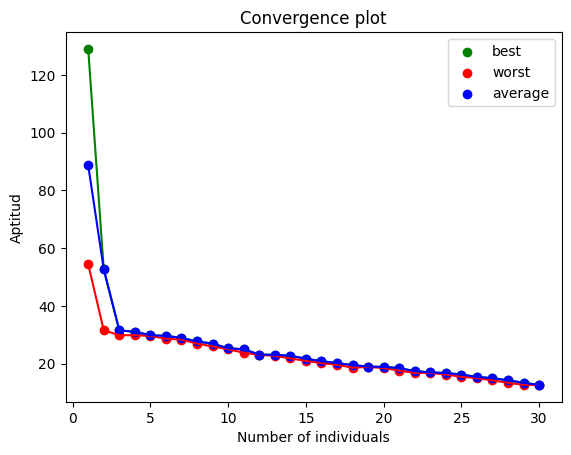

In [ ]:
best, bests, worsts, avgs = genetic_algo(20, 2, [-5.12, 5.12], 10, parabola, TwoCrossover, 3, 7, 0.23, 0.01, 0.001)
conv_plot(bests, worsts, avgs)

#### Same as above, although population = 50

Numer of iterations needed: 54

Global optimum approximation (best individual) is: [[-0.03000000000000022, 0.11999999999999997, -0.03999999999999998, -0.03000000000000022, 0.06, -5.551115123125783e-17, 0.0699999999999999, 0.04000000000000001, 0.01999999999999999, -0.010000000000000009], 0.0284]


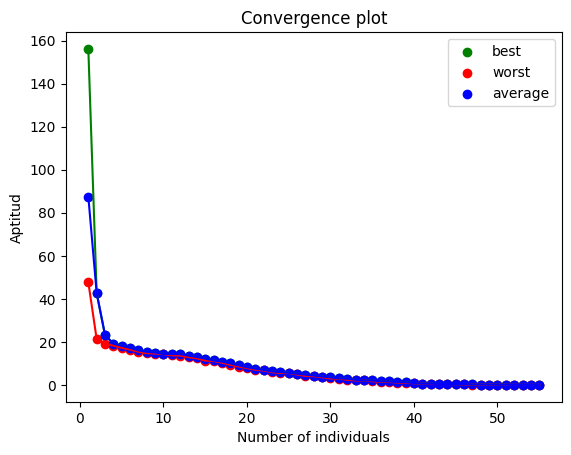

In [ ]:
best, bests, worsts, avgs = genetic_algo(50, 2, [-5.12, 5.12], 10, parabola, TwoCrossover, 3, 7, 0.23, 0.01, 0.001)
conv_plot(bests, worsts, avgs)

#### Same as above, although population = 100

Numer of iterations needed: 58

Global optimum approximation (best individual) is: [[-0.12000000000000008, 0.0999999999999997, 0.08000000000000004, 0.019999999999999962, -0.11000000000000001, -0.07000000000000003, 0.060000000000000026, -0.07999999999999999, 0.08000000000000004, 0.03], 0.06549999999999997]


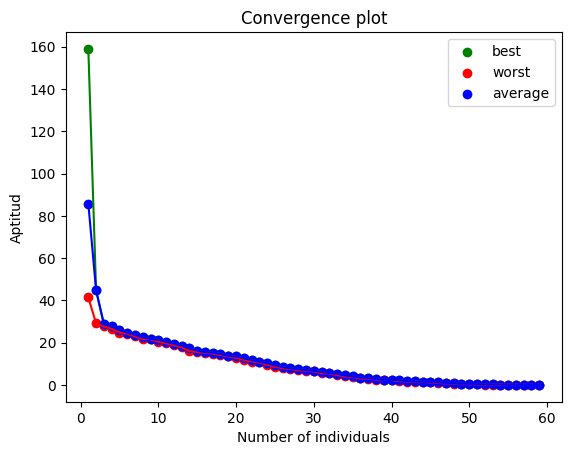

In [ ]:
best, bests, worsts, avgs = genetic_algo(100, 2, [-5.12, 5.12], 10, parabola, TwoCrossover, 3, 7, 0.23, 0.01, 0.001)
conv_plot(bests, worsts, avgs)

## Rosenbrock test

Numer of iterations needed: 19

Global optimum approximation (best individual) is: [[0.98, 0.8500000000000001, 0.8600000000000001, 0.78, 0.75, 0.53, 0.28, 0.01, 0.16, 0.08000000000000002], 11.282411999999992]


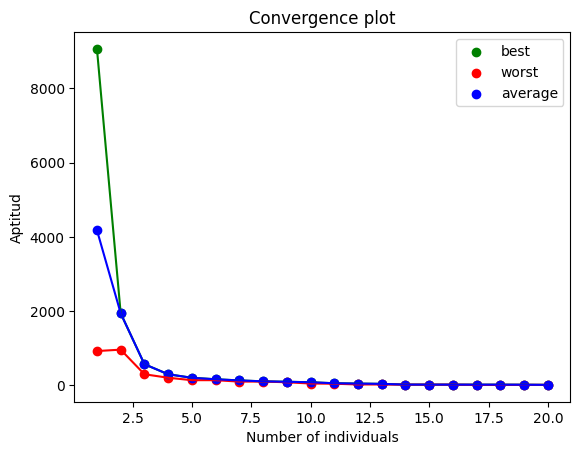

In [ ]:
best, bests, worsts, avgs = genetic_algo(100, 2, [-2.048, 2.048], 10, rosenbrock, TwoCrossover, 3, 7, 0.23, 0.01, 0.001)
conv_plot(bests, worsts, avgs)

## Ackley test

Numer of iterations needed: 7

Global optimum approximation (best individual) is: [[-2.048, 1.03, 0.98, -1.99, -1.01, 1.98, 1.97, 2.02, -0.03, -2.048], -18555.82129753589]


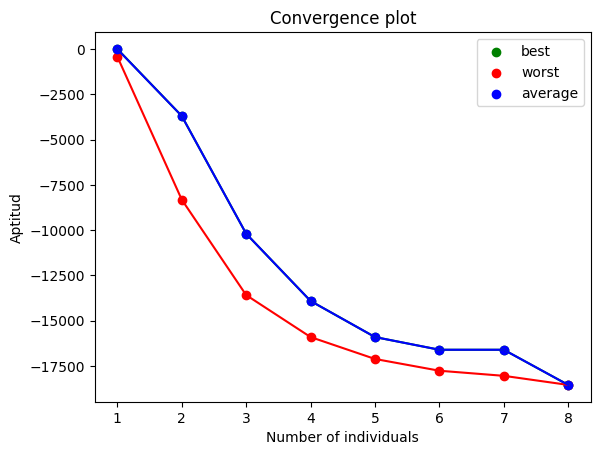

In [ ]:
best, bests, worsts, avgs = genetic_algo(500, 2, [-2.048, 2.048], 10, ackley, TwoCrossover, 3, 7, 0.23, 0.01, 0.001)
conv_plot(bests, worsts, avgs)